In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv("Daily_all_supervised.csv", index_col = "Date")

In [3]:
df.head(5)

,T-28,T-27,T-26,T-25,T-24,T-23,T-22,T-21,T-20,T-19,...,difference_28_1-5,difference_28_1-4,difference_28_1-3,difference_28_1-2,difference_28_1-1,difference_statistic_28_1_mean,tzero,Target_Tplus1,week_day,week_number
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-30,136.0,5.0,30.0,2146.0,2066.0,619.0,373.0,4.0,1071.0,1420.0,...,35.0,-77.0,-125.0,-56.0,232.0,25.000000,680,1058.0,6,26
2019-07-01,5.0,30.0,2146.0,2066.0,619.0,373.0,4.0,1071.0,1420.0,214.0,...,-77.0,-125.0,-56.0,232.0,378.0,38.074074,1058,1064.0,0,27
2019-07-02,30.0,2146.0,2066.0,619.0,373.0,4.0,1071.0,1420.0,214.0,1053.0,...,-125.0,-56.0,232.0,378.0,6.0,-40.074074,1064,1118.0,1,27
2019-07-03,2146.0,2066.0,619.0,373.0,4.0,1071.0,1420.0,214.0,1053.0,368.0,...,-56.0,232.0,378.0,6.0,54.0,-35.111111,1118,1130.0,2,27
2019-07-04,2066.0,619.0,373.0,4.0,1071.0,1420.0,214.0,1053.0,368.0,10.0,...,232.0,378.0,6.0,54.0,12.0,18.925926,1130,1030.0,3,27


In [4]:
test_size = 30
split_point = int(df.shape[0]-test_size)

In [5]:
df_train = df.iloc[0:split_point,:]
df_test = df.iloc[split_point:df.shape[0],:]

In [6]:
X_train = df_train.drop(columns = ["Target_Tplus1"], axis =1)
X_test = df_test.drop(columns = ["Target_Tplus1"], axis =1)

y_train = df_train["Target_Tplus1"]
y_test = df_test["Target_Tplus1"]

In [7]:
scaler = MinMaxScaler(feature_range = (0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))

In [9]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [10]:
X_train.shape

(898, 61, 1)

In [23]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 50))
regressor.add(Dense(units = 50))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
29/29 [==============================] - 5s 62ms/step - loss: 0.0241
Epoch 2/100
29/29 [==============================] - 2s 62ms/step - loss: 0.0178
Epoch 3/100
29/29 [==============================] - 2s 62ms/step - loss: 0.0178
Epoch 4/100
29/29 [==============================] - 2s 60ms/step - loss: 0.0172
Epoch 5/100
29/29 [==============================] - 2s 60ms/step - loss: 0.0127
Epoch 6/100
29/29 [==============================] - 2s 60ms/step - loss: 0.0091
Epoch 7/100
29/29 [==============================] - 2s 60ms/step - loss: 0.0081
Epoch 8/100
29/29 [==============================] - 2s 60ms/step - loss: 0.0078
Epoch 9/100
29/29 [==============================] - 2s 58ms/step - loss: 0.0080
Epoch 10/100
29/29 [==============================] - 2s 62ms/step - loss: 0.0078
Epoch 11/100
29/29 [==============================] - 2s 61ms/step - loss: 0.0076
Epoch 12/100
29/29 [==============================] - 2s 61ms/step - loss: 0.0066
Epoch 13/100
29/29 [=====

In [24]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [25]:
pred_demand = regressor.predict(X_test)
pred_demand = scaler.inverse_transform(pred_demand)

In [26]:
historical_demand = pd.DataFrame(df_train["Target_Tplus1"], index = df_train.index)#.tail(60)
pred_demand = pd.DataFrame(pred_demand, index = df_test.index, columns=["Target_Tplus1"])
obs_demand = pd.DataFrame(y_test, index = df_test.index,columns=["Target_Tplus1"])


In [27]:
pred_demand = pd.concat([historical_demand.tail(1), pred_demand])
obs_demand = pd.concat([historical_demand.tail(1), obs_demand])

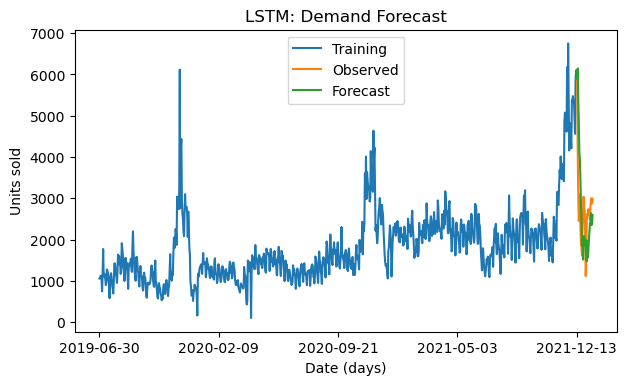

In [28]:
n = len(df_train)
ticks = [0,int(n/4), int((n*2)/4), int((n*3)/4), n-1]
labels = list(df_train.iloc[ticks].index)

plt.figure(figsize=(7,4), dpi=100)
plt.plot(historical_demand, label = 'Training')
plt.plot(obs_demand, label = 'Observed')
plt.plot(pred_demand, label = 'Forecast')
plt.xticks(ticks, labels)
plt.title('LSTM: Demand Forecast')
plt.xlabel('Date (days)')
plt.ylabel('Units sold')
plt.legend()
plt.show()

In [29]:
mean_absolute_percentage_error(obs_demand, pred_demand)

0.3039602889892488

In [30]:
mean_absolute_error(obs_demand, pred_demand)

778.0179600869455

In [31]:
mean_squared_error(obs_demand, pred_demand)

971544.2049166093